In [1]:
## Make sure plots are create inline
%matplotlib inline
## The usual packages (numpy, matplotlib, etc)
from RSE_style import *
from scipy.interpolate import interp1d
from scipy.ndimage.filters import gaussian_filter1d
from mpl_toolkits.basemap import Basemap
import h5py as h5
import os
from scipy.interpolate import UnivariateSpline
from IPython.display import clear_output

In [2]:
def ForwardModel(x, PC, wl_grid, SIF, compK = False):
    
    # Legendre polynomials
    P1 = wl_grid
    P2 = 1/2*(wl_grid**2 - 1)
    P3 = 1/2*(5*wl_grid**3 - 3*wl_grid)
    F = (x[0] * PC[0] + x[1] * PC[1] + x[2] * PC[2] + x[3] * PC[3] + x[4] * PC[4] 
        + x[5] * P1 * PC[0] + x[6] * P2 * PC[0] + x[7] * P3 * PC[0] + x[8] * SIF)
    
    if compK == True:
        # Jacobian
        K = np.zeros((122, 9))
        K[:, 0] = PC[0]
        K[:, 1] = PC[1]
        K[:, 2] = PC[2]
        K[:, 3] = PC[3]
        K[:, 4] = PC[4]
        K[:, 5] = P1*PC[0]
        K[:, 6] = P2*PC[0]
        K[:, 7] = P3*PC[0]
        K[:, 8] = SIF
        return F, K
    else:
        return F

In [3]:
def ForwardModelNUM(x, PC, wl_grid, SIF, compK = False):
    P1 = wl_grid
    P2 = 1/2*(wl_grid**2 - 1)
    P3 = 1/2*(5*wl_grid**3 - 3*wl_grid)
    F = x[0] * PC[0] + x[1] * PC[1] + x[2] * PC[2] + x[3] * PC[3] + x[4] * PC[4] + x[5] * P1 * PC[0] + x[6] * P2 * PC[0] + x[7] * P3 * PC[0] + x[8] * SIF
    
    if compK == True:
        K = np.zeros((122, 9))
        perturbmat = np.diag(np.ones(9,))
        dx = 1e-10
        for k in range(9):
            K[:, k] = (ForwardModelNUM(x + perturbmat[:, k]*dx, PC, wl_grid, SIF) - ForwardModelNUM(x - perturbmat[:, k]*dx, PC, wl_grid, SIF))/(2*dx)
        return F, K
    else:
        return F

In [4]:
def plotfile(filename, directory):
    import os
    file_nadir = os.path.join(directory, filename)
    fn = h5.File(file_nadir)
    lat = fn['BAND6_RADIANCE/STANDARD_MODE/GEODATA/latitude'][0,:,:]
    lon = fn['BAND6_RADIANCE/STANDARD_MODE/GEODATA/longitude'][0,:,:]
    sza = fn['BAND6_RADIANCE/STANDARD_MODE/GEODATA/solar_zenith_angle'][0,:,:]
    fn.close
    # Plot the solar spectrum sample area
    m = Basemap(projection='robin', lon_0=-120, resolution='c')
    figsize(16,10)
    m.scatter(lon[sza<60], lat[sza<60], 0.0001, marker='D', latlon=True)
    m.drawcoastlines()
    plt.title('Solar spectrum sample area for this file')
    print('lat', np.max(np.max(lat[sza<60])), np.min(np.min(lat[sza<60])))
    print('lon', np.max(np.max(lon[sza<60])), np.min(np.min(lon[sza<60])))

In [5]:
# Get SIF shape and wl grid
f = h5.File('/Users/owinton/Documents/TROPOMI/PS_SIF_map.h5','r')
SIF_spec = f['SIF_shape'][:]
SIF_wl = f['wlGrid'][:]
f.close()

lat 52.725933 -66.31461
lon -93.317924 -161.85733


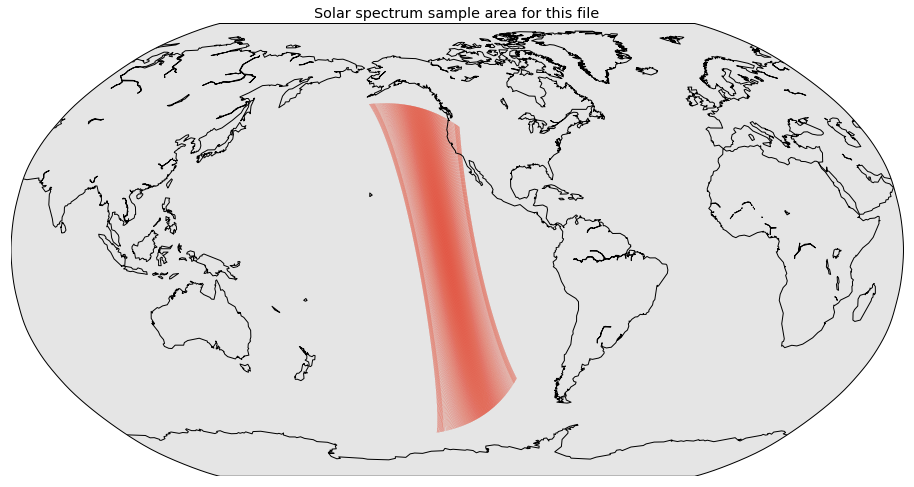

In [6]:
directory = '/Users/owinton/Documents/TROPOMI/'
filename = 'S5P_OFFL_L1B_RA_BD6_20181011T205656_20181011T223825_05157_01_010000_20181012T002841.zip'
plotfile(filename, directory)

### Getting the Principal Components from SVD

####  Get a lot of SIF-free spectra for each detector spatial pixel

In [7]:
# Get 150 spectra for each pixel (footprint, one pixel in swath)
directory = '/Users/owinton/Documents/TROPOMI/TROPOMI_SAHARA/'
nspec = 400
spec_pixel_all = np.zeros((nspec, 408, 497))
wl_pixel_all = np.zeros((408, 497))
count = np.zeros((408))
samplelat = np.zeros((nspec, 408))
samplelon = np.zeros((nspec, 408))

# Check each file
for filename in os.listdir(directory):
    if count.all == 400:
        continue
    if filename.endswith('.zip'):
        file_nadir = os.path.join(directory, filename)
        fn = h5.File(file_nadir)
        # Get the data, remove 20 pixels on each edge
        lat = fn['BAND6_RADIANCE/STANDARD_MODE/GEODATA/latitude'][0,:,20:428]
        lon = fn['BAND6_RADIANCE/STANDARD_MODE/GEODATA/longitude'][0,:,20:428]
        sza = fn['BAND6_RADIANCE/STANDARD_MODE/GEODATA/solar_zenith_angle'][0,:,20:428]
        wl_spec = fn['BAND6_RADIANCE/STANDARD_MODE/INSTRUMENT/nominal_wavelength'][0,20:428,:]
        spec = fn['BAND6_RADIANCE/STANDARD_MODE/OBSERVATIONS/radiance'][0,:,20:428,:]
        fn.close()
        
        # For each pixel (get rid of 20 edge pixels on each side)
        for pixel in range(408):
            # wl_grid is defined within the pixel
            wl_pixel_all[pixel, :] = wl_spec[pixel, :]
            # Check each swath
            for swath in range(np.shape(lat)[0]):
                # Find spectra in Sahara, until 150 spectra are obtained
                if (lat[swath, pixel] > 18 and lat[swath,pixel] < 28 and lon[swath,pixel] > -8 and lon[swath,pixel] < 28 and sza[swath, pixel] < 40 and count[pixel] < nspec):
                    spec_pixel_all[int(count[pixel]), pixel, :] = spec[swath, pixel, :]
                    samplelat[int(count[pixel]), pixel] = lat[swath,pixel]
                    samplelon[int(count[pixel]), pixel] = lon[swath,pixel]
                    count[pixel] += 1
                if (lat[swath, pixel] > -60 and lat[swath, pixel] < 10 and lon[swath, pixel] > -160 and lon[swath, pixel] < - 90 and sza[swath, pixel] < 40 and count[pixel] < nspec):
                    spec_pixel_all[int(count[pixel]), pixel, :] = spec[swath, pixel, :]
                    samplelat[int(count[pixel]), pixel] = lat[swath,pixel]
                    samplelon[int(count[pixel]), pixel] = lon[swath,pixel]
                    count[pixel] += 1
            # Give progress info
            clear_output(wait=True)
            print("Current progress",pixel+1, "pixels done")


Current progress 408 pixels done


Text(0.5,1,'Solar spectrum sample area')

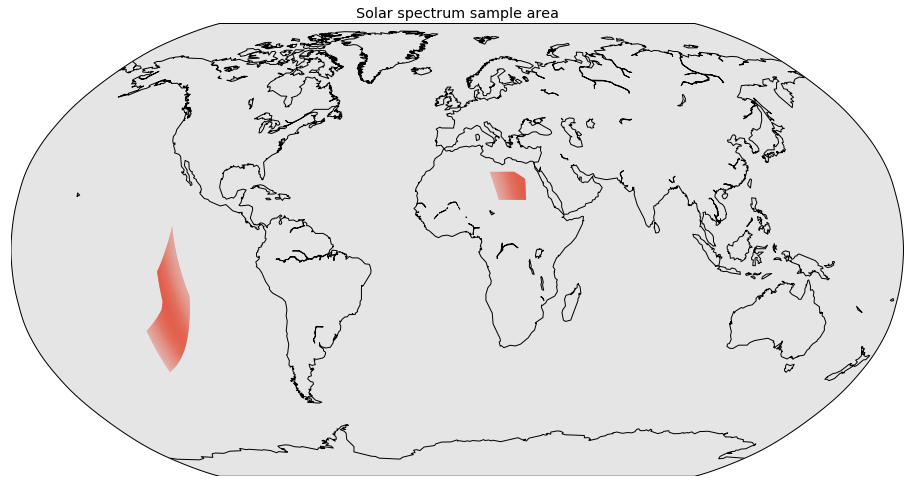

In [8]:
# Plot the solar spectrum sample area
m = Basemap(projection='robin', lon_0=0, resolution='c')
figsize(16,10)
m.scatter(samplelon, samplelat, 0.0001, marker='D', latlon=True)
m.drawcoastlines()
plt.title('Solar spectrum sample area')

In [9]:
# Get the first 122 wavelengths above 743 nm, this is our retrieval area. 
# Fixed amount of spectral values in each pixel to make matrices easier
wl_spec = np.zeros((408, 122))
spec = np.zeros((nspec, 408, 122))
for pixel in range(408):
    index = wl_pixel_all[pixel, :] > 743
    wl_pixel = wl_pixel_all[pixel, index]
    wl_spec[pixel, :] = wl_pixel[:122]
    for swath in range(nspec):
        spec_pixel = spec_pixel_all[swath, pixel, index]
        spec[swath, pixel, :] = spec_pixel[:122]

### Do the SVD and show some of the PC-functions and their explained variance

In [10]:
u = np.zeros((408, nspec, nspec))
s = np.zeros((408, 122))
vh = np.zeros((408, 122, 122))
for pixel in range(408):
    u[pixel,:,:], s[pixel,:], vh[pixel,:,:] = np.linalg.svd(spec[:, pixel, :])
    # For each pixel, the rows (vh is v transposed) are the eigen vectors;
    # Use the first 5 as principal components for SIF-free spectra i.e. 'pure' reflected solar spectrum

[1.84003913e-04 5.33007991e-07 6.49660517e-08 5.08475136e-08
 2.78622524e-08 9.46578852e-09 8.73034940e-09 8.56498481e-09
 8.02196098e-09 7.88028819e-09]


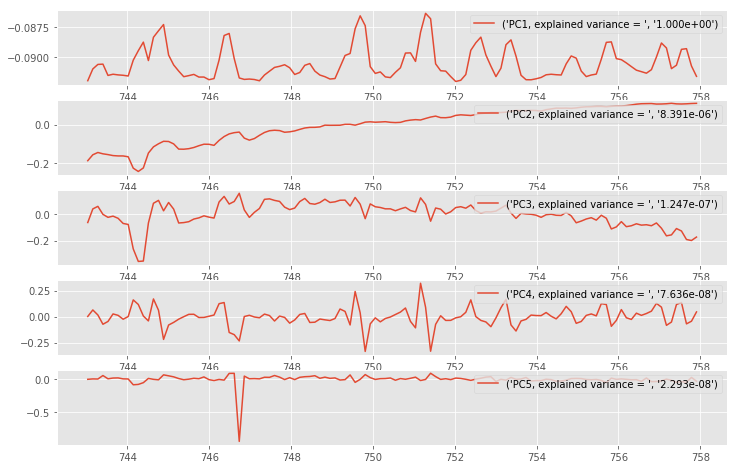

In [11]:
# Showing the Principal component functions, along with their explained variance 
# (defined correctly? Only takes into account the relative value of singualr values)
figsize(12,8)
plt.subplot(511)
test_pixel = 200
plt.plot(wl_spec[test_pixel,:],vh[test_pixel,0,:],label=('PC1, explained variance = ', '{:0.3e}'.format(s[test_pixel,0]**2/(s[test_pixel,:].dot(s[test_pixel,:].T)))))
plt.legend(loc=1)
#plt.yticks([])
plt.subplot(512)
plt.plot(wl_spec[test_pixel,:],vh[test_pixel,1,:],label=('PC2, explained variance = ', '{:0.3e}'.format(s[test_pixel,1]**2/(s[test_pixel,:].dot(s[test_pixel,:].T)))))
plt.legend(loc=1)
#plt.yticks([])
plt.subplot(513)
plt.plot(wl_spec[test_pixel,:],vh[test_pixel,2,:],label=('PC3, explained variance = ', '{:0.3e}'.format(s[test_pixel,2]**2/(s[test_pixel,:].dot(s[test_pixel,:].T)))))
plt.legend(loc=1)
#plt.yticks([])
plt.subplot(514)
plt.plot(wl_spec[test_pixel,:],vh[test_pixel,3,:],label=('PC4, explained variance = ', '{:0.3e}'.format(s[test_pixel,3]**2/(s[test_pixel,:].dot(s[test_pixel,:].T)))))
plt.legend(loc=1)
#plt.yticks([])
plt.subplot(515)
plt.plot(wl_spec[test_pixel,:],vh[test_pixel,4,:],label=('PC5, explained variance = ', '{:0.3e}'.format(s[test_pixel,4]**2/(s[test_pixel,:].dot(s[test_pixel,:].T)))))
plt.legend(loc=1)

print(s[test_pixel,0:10])


### Testing one single retrieval

In [12]:
swath, pixel = 200, 100
PC = vh[pixel, 0:5]
wl_grid = wl_spec[pixel, :]
spl = UnivariateSpline(SIF_wl, SIF_spec, k=3, s=0)
SIF = spl(wl_grid)*1e-10
F, K = ForwardModel(np.ones(9), PC, wl_grid, SIF, True)
spec_it = spec[swath, pixel, :]
noise = 0*0.006014361 + 0.003470511 * np.sqrt(spec_it)
invSe = np.diag(1/noise**2)

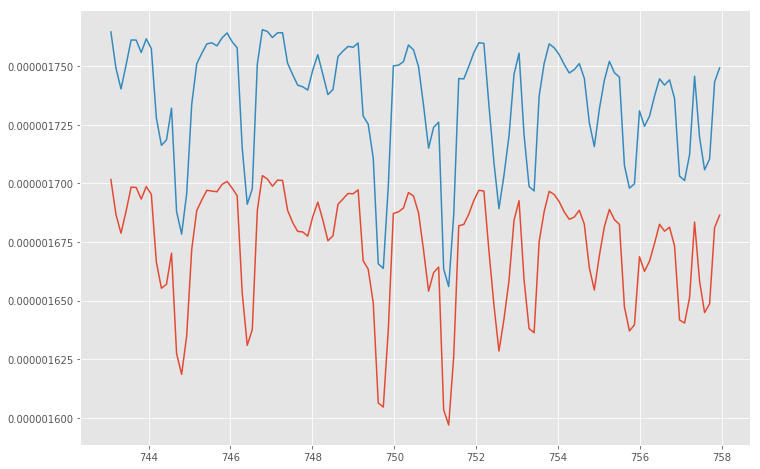

In [13]:
x = np.linalg.inv(K.T.dot(K)).dot(K.T).dot(spec_it)
plt.plot(wl_grid,spec_it, wl_grid, ForwardModel(x, PC, wl_grid, SIF, False))

### Testing retrieval on Sahara pixels

In [14]:
spl = UnivariateSpline(SIF_wl, SIF_spec, k=3, s=0)
# Factor for weighing the singular value of PC1:5 in terms of variance. 
factor = 1
xhat = np.zeros((nspec, 408, 9))
residuals = np.zeros((nspec, 408, 122))
# Prior to constrain higher order Principal components to a mean of 0.
# Here all state vector elements are given a mean of 0, 
# The amount of constraint is then defined in the variance in Sa
xa = np.zeros((9,))
for pixel in range(408):
    # Singular values for this pixel
    sv = s[pixel,0:5]
    Sa = np.array([1e20, factor*sv[1], factor*sv[2], factor*sv[3], factor*sv[4], 1e20, 1e20, 1e20, 1e20])
    invSa = np.diag(1/Sa)
    # The Principal component
    PC = vh[pixel, 0:5, :]
    # The wl_grid and SIF for this pixel
    wl_grid = wl_spec[pixel, :]
    SIF = spl(wl_grid)
    # Get the Jacobian, it's the same for each pixel
    F, K = ForwardModel(np.ones(9), PC, wl_grid, SIF, True)
    for swath in range(nspec):
        spec_it = spec[swath, pixel, :]
        # Noise model
        noise = 0.006014361 + 0.003470511 * np.sqrt(spec_it)
        invSe = np.diag(1/noise**2)
        # Linear retrieval with prior
        # xhat[swath, pixel, :] = np.linalg.inv( K.T.dot(invSe).dot(K) + invSa ).dot( (K.T).dot(invSe).dot(spec_it) + invSa.dot(xa) )
        xhat[swath, pixel, :] = np.linalg.inv( K.T.dot(invSe).dot(K)  ).dot( (K.T).dot(invSe).dot(spec_it) )
        # xhat[swath, pixel, :] = np.linalg.inv( K.T.dot(K)  ).dot( (K.T).dot(spec_it) )

        # Save the residuals
        residuals[swath, pixel, :] = spec_it - ForwardModel(xhat[swath, pixel, :], PC, wl_grid, SIF)
    
    # Progress info
    clear_output(wait=True)
    print("Current progress",np.round(((pixel+1)/408) * 100, 1), "%")
        

Current progress 100.0 %


Text(0.5,1,'SIF retrievals')

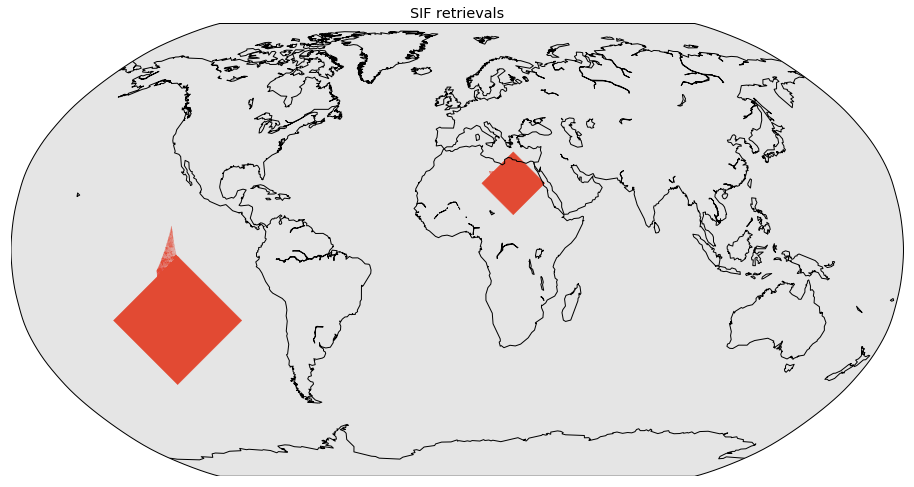

In [15]:
SIF_retrievals = xhat[:, :, 8]
m = Basemap(projection='robin', lon_0=0, resolution='c')
figsize(16,10)
# I don't know how to show ungridded data best, scatter does not handle negative radii well
m.scatter(samplelon, samplelat, 1e14*SIF_retrievals**2, marker='D', latlon=True)
m.drawcoastlines()
plt.title('SIF retrievals')

### There are shifts

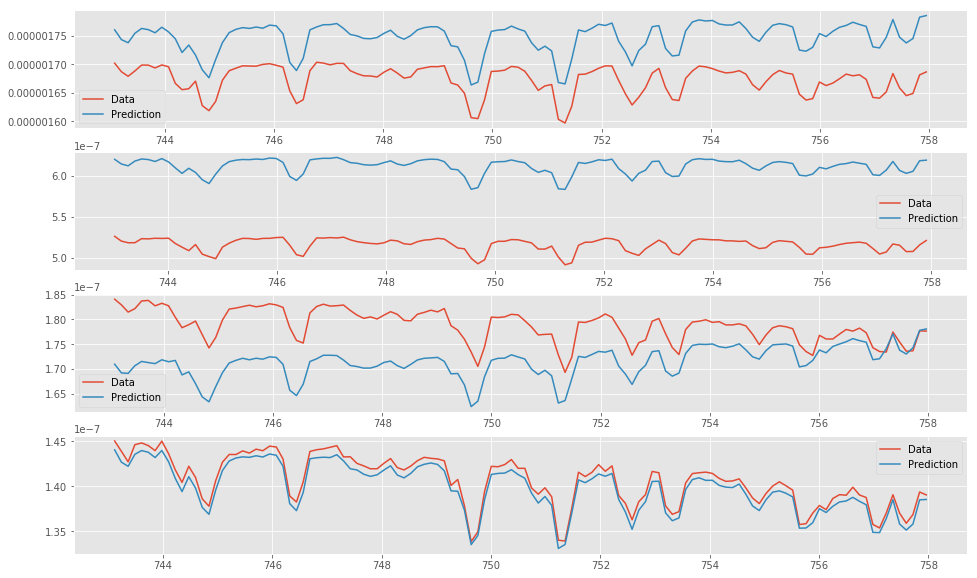

In [16]:
plt.subplot(411)
swath, pixel = 200, 100
plt.plot(wl_spec[pixel,:],spec[swath, pixel, :], wl_spec[pixel, :], ForwardModel(xhat[swath, pixel, :], PC, wl_spec[pixel, :], SIF))
plt.legend(['Data','Prediction'])
plt.subplot(412)
swath, pixel = 200, 200
plt.plot(wl_spec[pixel,:],spec[swath, pixel, :], wl_spec[pixel, :], ForwardModel(xhat[swath, pixel, :], PC, wl_spec[pixel, :], SIF))
plt.legend(['Data','Prediction'])
plt.subplot(413)
swath, pixel = 200, 300
plt.plot(wl_spec[pixel,:],spec[swath, pixel, :], wl_spec[pixel, :], ForwardModel(xhat[swath, pixel, :], PC, wl_spec[pixel, :], SIF))
plt.legend(['Data','Prediction'])
plt.subplot(414)
swath, pixel = 10, 407
plt.plot(wl_spec[pixel,:],spec[swath, pixel, :], wl_spec[pixel, :], ForwardModel(xhat[swath, pixel, :], PC, wl_spec[pixel, :], SIF))
plt.legend(['Data','Prediction'])

In [17]:
xhat[200, 300]

array([-1.23104453e-03, -2.03922923e-08, -5.13159470e-09, -1.92555605e-09,
       -8.95283847e-12,  4.89584636e-06, -1.29930413e-08,  1.14877552e-12,
        4.03852596e-09])

### Retrieval of one file at a time

In [18]:
directory = '/Users/owinton/Documents/TROPOMI/TROPOMI_SAHARA'
filename = 'S5P_OFFL_L1B_RA_BD6_20181012T102851_20181012T121021_05165_01_010000_20181012T140022.zip'
file_nadir = os.path.join(directory, filename)
fn = h5.File(file_nadir)
lat = fn['BAND6_RADIANCE/STANDARD_MODE/GEODATA/latitude'][0,:,20:428]
lon = fn['BAND6_RADIANCE/STANDARD_MODE/GEODATA/longitude'][0,:,20:428]
sza = fn['BAND6_RADIANCE/STANDARD_MODE/GEODATA/solar_zenith_angle'][0,:,20:428]
wl_spec = fn['BAND6_RADIANCE/STANDARD_MODE/INSTRUMENT/nominal_wavelength'][0,20:428,:]
spec = fn['BAND6_RADIANCE/STANDARD_MODE/OBSERVATIONS/radiance'][0,:,20:428,:]
fn.close()

In [19]:
# Get the first 122 wavelengths above 743 nm, this is our retrieval area. 
# Fixed amount of spectral values in each pixel to make matrices easier
spec_pixel_trunc = np.zeros((lat.shape[0], 408, 122))
wl_pixel_trunc = np.zeros((408, 122))
for pixel in range(408):
    index_pixel = wl_pixel_all[pixel, :] > 743
    wl_pixel = wl_pixel_all[pixel, index_pixel]
    wl_pixel_trunc[pixel, :] = wl_pixel[:122]
    for swath in range(lat.shape[0]):
        spec_pixel = spec[swath, pixel, index_pixel]
        spec_pixel_trunc[swath, pixel, :] = spec_pixel[:122]
wl_spec = wl_pixel_trunc
spec = spec_pixel_trunc

In [20]:
spl = UnivariateSpline(SIF_wl, SIF_spec, k=3, s=0)
factor = 1
xhat = np.zeros((lat.shape[0], lat.shape[1], 9))
residuals = np.zeros((lat.shape[0], lat.shape[1], 122))
xa = np.zeros((9,))
for pixel in range(408):
    sv = s[pixel,0:5]
    Sa = np.array([1e20, factor*sv[1], factor*sv[2], factor*sv[3], factor*sv[4], 1e20, 1e20, 1e20, 1e20])
    invSa = np.diag(1/Sa)
    PC = vh[pixel, 0:5, :]
    wl_grid = wl_spec[pixel, :]
    SIF = spl(wl_grid)
    F, K = ForwardModel(np.ones(9), PC, wl_grid, SIF, True)
    for swath in range(lat.shape[0]):
        #if (spec[swath, pixel, :]<0).any() or sza[swath, pixel] < 60:
        #    break
        #else:
        if sza[swath, pixel] < 60:
            noise = 0.006014361 + 0.003470511 * np.sqrt(spec_it)
            invSe = np.diag(1/noise**2)
            spec_it = spec[swath, pixel, :]
            xhat[swath, pixel, :] = np.linalg.inv( K.T.dot(invSe).dot(K) + invSa ).dot( (K.T).dot(invSe).dot(spec_it) + invSa.dot(xa) )
            residuals[swath, pixel, :] = spec_it - ForwardModel(xhat[swath, pixel, :], PC, wl_grid, SIF)
    clear_output(wait=True)
    print("Current progress",np.round(((pixel+1)/408) * 100, 1), "%")

   

Current progress 100.0 %


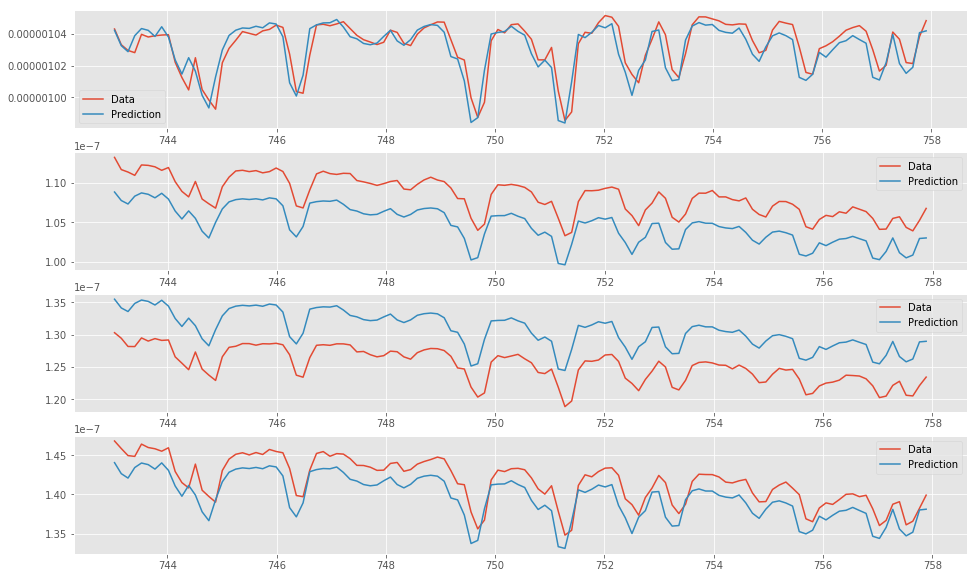

In [21]:
plt.subplot(411)
swath, pixel = 2000, 200
plt.plot(wl_spec[pixel,:],spec[swath, pixel, :], wl_spec[pixel, :], ForwardModel(xhat[swath, pixel, :], PC, wl_grid, SIF))
plt.legend(['Data','Prediction'])
plt.subplot(412)
swath, pixel = 2000, 395
plt.plot(wl_spec[pixel,:],spec[swath, pixel, :], wl_spec[pixel, :], ForwardModel(xhat[swath, pixel, :], PC, wl_grid, SIF))
plt.legend(['Data','Prediction'])
plt.subplot(413)
swath, pixel = 2000, 400
plt.plot(wl_spec[pixel,:],spec[swath, pixel, :], wl_spec[pixel, :], ForwardModel(xhat[swath, pixel, :], PC, wl_grid, SIF))
plt.legend(['Data','Prediction'])
plt.subplot(414)
swath, pixel = 2000, 405
plt.plot(wl_spec[pixel,:],spec[swath, pixel, :], wl_spec[pixel, :], ForwardModel(xhat[swath, pixel, :], PC, wl_grid, SIF))
plt.legend(['Data','Prediction'])

Text(0.5,1,'SIF retrievals')

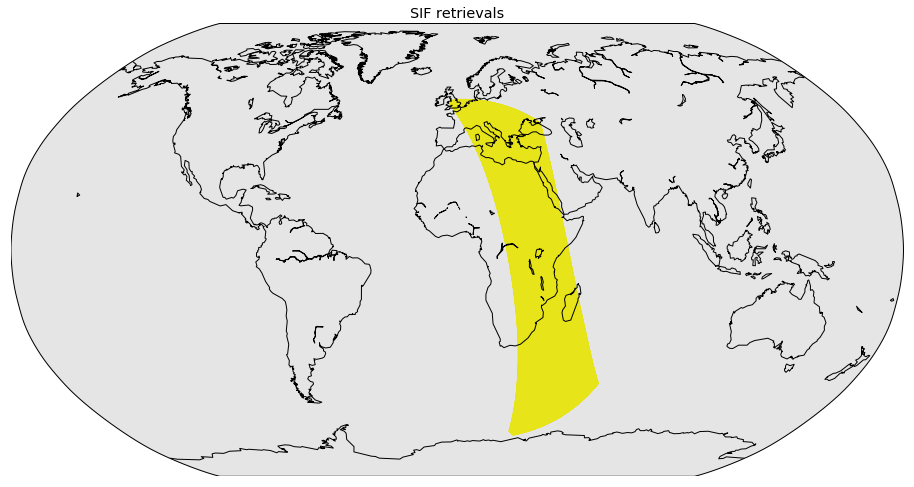

In [22]:
SIF_retrievals = xhat[:, :, 8]
m = Basemap(projection='robin', lon_0=0, resolution='c')
figsize(16,10)
m.scatter(lon[sza<60], lat[sza<60], SIF_retrievals[sza<60], marker='D', latlon=True)
m.drawcoastlines()
plt.title('SIF retrievals')
